In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import os
import dill
from xgboost import XGBClassifier
from sklearn.metrics import (
    recall_score, precision_score, balanced_accuracy_score, f1_score,
    average_precision_score, precision_recall_curve, roc_auc_score
)

In [ ]:
base_path = Path("/home/lars/code/syeda-tabassum-rahaman/scam-job-detector")
data_path = base_path / "raw_data" / "data_cleaned.csv"

df = pd.read_csv(data_path)

In [ ]:
# combining text columns
FIELDS = [
    ("title", "TITLE"),
    ("description", "DESCRIPTION"),
    ("requirements", "REQUIREMENTS"),
    ("benefits", "BENEFITS"),
    ("company_profile", "COMPANY_PROFILE"),
]

def clean_text(x: str) -> str:
    x = "" if x is None else str(x)
    return " ".join(x.split()) 

def concat_job_row(row: pd.Series, sep: str = " [SEP] ") -> str:
    parts = []
    for col, tag in FIELDS:
        txt = clean_text(row.get(col, ""))
        if txt:
            parts.append(f"{tag}: {txt}")
    return sep.join(parts)

cols = ["title", "description", "benefits", "company_profile", "requirements"]
print(cols)
df[cols] = df[cols].fillna("")

df['full_text'] = df[cols].apply(concat_job_row, axis=1)


['title', 'description', 'benefits', 'company_profile', 'requirements']


In [ ]:
# Setting up the model
MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
bert = AutoModel.from_pretrained(MODEL)
bert.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
# creating function to convert text and train the bert embedding model

# def bert_embed(texts, tokenizer, bert, max_length=256, batch_size=32):
#     all_vecs = []

#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i+batch_size]

#         enc = tokenizer(
#             batch,
#             truncation=True,
#             padding=True,
#             max_length=max_length,
#             return_tensors="pt"
#         )

#         with torch.no_grad():
#             out = bert(**enc)  # out.last_hidden_state: [B, T, H]
#             cls_vec = out.last_hidden_state[:, 0, :]  # [B, H]

#         all_vecs.append(cls_vec.cpu().numpy())

#     return np.vstack(all_vecs)  # shape: [N, H]
def bert_embed_meanpool(texts, tokenizer, bert, max_length=256, batch_size=32):
    import numpy as np, torch

    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")

        with torch.no_grad():
            out = bert(**enc)  # last_hidden_state: [B,T,H]
            hs = out.last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)  # [B,T,1]

            summed = (hs * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            meanpooled = summed / counts  # [B,H]

        all_vecs.append(meanpooled.cpu().numpy())
    return np.vstack(all_vecs)



(0.0, 1.0)

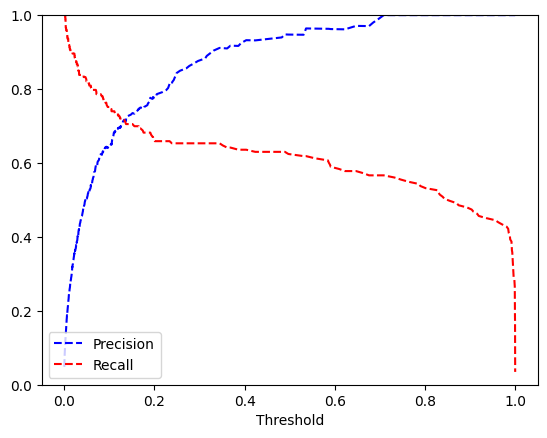

In [38]:
import matplotlib.pyplot as plt
precision, recall, threshold = precision_recall_curve(y_test, y_pred_xgb_proba)

plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])


In [10]:
from sklearn.model_selection import train_test_split

idx = df.index.to_numpy()
idx_train, idx_val = train_test_split(idx, test_size=0.2, random_state=42, stratify=df["fraudulent"])


X_train = df.loc[idx_train, "full_text"].tolist()
y_train = df.loc[idx_train, "fraudulent"].astype(int).tolist()
X_val   = df.loc[idx_val, "full_text"].tolist()
y_val   = df.loc[idx_val, "fraudulent"].astype(int).tolist()

extra_cols = ["has_company_logo", "has_questions"]  # <- your one-hot column names
E_train = df.loc[idx_train, extra_cols].to_numpy(dtype="float32")
E_val   = df.loc[idx_val, extra_cols].to_numpy(dtype="float32")
    

In [ ]:
X_train_vec = bert_embed_meanpool(X_train, tokenizer, bert)
X_val_vec   = bert_embed_meanpool(X_val, tokenizer, bert)

X_train_all = np.hstack([X_train_vec, E_train])
X_val_all   = np.hstack([X_val_vec,   E_val])

In [ ]:
# Preprocess once
X_train_pp = X_train_all
X_test_pp = X_val_all
y_test = y_val
y_train = y_train

# Paths for saving models
base_path = "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/"
models_folder = os.path.join(base_path, "models")
os.makedirs(models_folder, exist_ok=True)

model_path = os.path.join(models_folder, "final_model.dill")


pos = sum(y_train)
neg = len(y_train) - pos
spw = neg / pos


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=275,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=spw,
)


xgb.fit(X_train_pp, y_train)
with open(model_path, "wb") as f:
    dill.dump(xgb, f)

y_pred = xgb.predict(X_test_pp)
y_pred_xgb_proba =xgb.predict_proba(X_test_pp)[:, 1]
print(f'''
    Model Performance
    Recall: {recall_score(y_test, y_pred)},
    Precision: {precision_score(y_test, y_pred)},
    Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)},
    F1 Score: {f1_score(y_test, y_pred)},
    AUC: {roc_auc_score(y_test, y_pred_xgb_proba)}
    ''')


# Explaining XGB

In [2]:
import pandas as pd
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score,
    balanced_accuracy_score)
import scam_job_detector.ML_logic.preprocessor as pre
print("Imported from:", pre.__file__)
print("Functions available:", dir(pre))
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor
from scam_job_detector.ML_logic.model import load_preprocessor, load_model
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
import shap
from wordcloud import WordCloud
import xgboost as xgb
from scam_job_detector.ML_logic.explainability import explain_xgb

Imported from: /home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/ML_logic/preprocessor.py
Functions available: ['ColumnTransformer', 'OneHotEncoder', 'OrdinalEncoder', 'SimpleImputer', 'TfidfVectorizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'binary_columns', 'categorical_columns', 'dill', 'make_column_transformer', 'make_pipeline', 'np', 'os', 'pd', 'preprocessing_pipeline', 'test_preprocessor', 'text_columns', 'train_preprocessor']


/home/lars/.pyenv/versions/scam_job_detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
base_path = Path("/home/lars/code/syeda-tabassum-rahaman/scam-job-detector")
data_path = base_path / "raw_data" / "data_cleaned.csv"

df = pd.read_csv(data_path)
# X_new = df.sample(1).drop(columns='fraudulent')
X_new = df.sample(500).drop(columns='fraudulent')

In [4]:

import numpy as np
import pandas as pd
import xgboost as xgb

# load model and preprocessor from disk (assumed to exist in your codebase)
model = load_model()
preprocessor = load_preprocessor()

# input: X_new must be in the same raw format the preprocessor expects
X_new_preprocessed = preprocessor.transform(X_new)

# get per-feature prediction contributions (SHAP-style + bias as last column)
dmat = xgb.DMatrix(X_new_preprocessed)
contribs = model.get_booster().predict(dmat, pred_contribs=True)

# build contributions dataframe for the first row in X_new
feature_names = preprocessor.get_feature_names_out()
contrib_df = pd.DataFrame(
    {
        "feature": feature_names,
        "contribution": contribs[0, :-1],  # exclude bias term
    }
)
contrib_df["abs_contribution"] = contrib_df["contribution"].abs()

# split text vs non-text features
text_mask = contrib_df["feature"].str.contains("tfidfvectorizer__", na=False)

xgb_text_df = contrib_df.loc[text_mask].copy()
xgb_cat_df  = contrib_df.loc[~text_mask].copy()

# keep only non-zero contributions for text features (optional)
xgb_text_df = xgb_text_df.loc[xgb_text_df["abs_contribution"] > 0].copy()

# explanations for non-text contributions
def extract_non_text_contributions(df: pd.DataFrame) -> list[str]:
    explanations = []
    for row in df.itertuples(index=False):
        feat = row.feature
        contrib = row.contribution

        if "has_company_logo" in feat:
            # more robust than "_0" in feat (avoids accidental matches)
            if feat.endswith("_0"):
                if contrib > 0:
                    explanations.append("Missing company logo increases the likelihood that this job posting is fake.")
                else:
                    explanations.append("Despite the missing company logo, other signals suggest this posting may be legitimate.")
            elif feat.endswith("_1"):
                if contrib > 0:
                    explanations.append("The presence of a company logo increases the likelihood that this job posting is fake (per this model).")
                else:
                    explanations.append("The presence of a company logo increases the credibility of the job posting.")
            else:
                explanations.append("Company logo feature contributes, but its exact level is unclear.")

        elif "country_" in feat:
            country = feat.split("country_")[-1]
            if contrib > 0:
                explanations.append(f"Job postings originating from {country} are statistically more likely to be fraudulent (per training data).")
            else:
                explanations.append(f"Job postings originating from {country} are generally less associated with fraud in the training data.")

        else:
            # fallback: show a generic statement including the feature name
            direction = "increases" if contrib > 0 else "decreases"
            explanations.append(f"Feature '{feat}' {direction} the fraud score (contribution={contrib:.4f}).")

    return explanations

xgb_cat_df["explanation"] = extract_non_text_contributions(xgb_cat_df)

# word extraction for text features
def extract_word(feature: str) -> str:
    return feature.split("tfidfvectorizer__", 1)[-1]

xgb_text_df["word"] = xgb_text_df["feature"].apply(extract_word)

# top contributing words
xgb_text_df_fake = (
    xgb_text_df.loc[xgb_text_df["contribution"] > 0]
    .sort_values("contribution", ascending=False)
    .head(20)
)

xgb_text_df_real = (
    xgb_text_df.loc[xgb_text_df["contribution"] < 0]
    .sort_values("contribution", ascending=True)
    .head(20)
)

# outputs
print("X_new (raw):")
print(pd.DataFrame(X_new).head(1))

print("\nNon-text explanations (top 30 by absolute contribution):")
print(
    xgb_cat_df.sort_values("abs_contribution", ascending=False)
    .head(30)[["feature", "contribution", "explanation"]]
    .to_string(index=False)
)

print("\nTop 20 words pushing towards FAKE:")
print(xgb_text_df_fake[["word", "contribution"]].to_string(index=False))

print("\nTop 20 words pushing towards REAL:")
print(xgb_text_df_real[["word", "contribution"]].to_string(index=False))

# If you still want the lists:
non_text_contributions = xgb_cat_df["explanation"].tolist()
text_contributions_words_fake = xgb_text_df_fake["word"].tolist()
text_contributions_contribution_fake = xgb_text_df_fake["contribution"].tolist()
text_contributions_words_real = xgb_text_df_real["word"].tolist()
text_contributions_contribution_real = xgb_text_df_real["contribution"].tolist()

print("\nWords pushing towards FAKE (list):")
print(text_contributions_words_fake)



✅ Model loaded
✅ Preprocessor loaded
X_new (raw):
      has_company_logo employment_type            industry function  \
4306                 1       Full-time  Telecommunications    Sales   

                                        job_description country  
4306  sales advisor energy aquira help businesses se...      GB  

Non-text explanations (top 30 by absolute contribution):
                                                 feature  contribution                                                                                                         explanation
                          pipeline-2__has_company_logo_0     -0.828162                             Despite the missing company logo, other signals suggest this posting may be legitimate.
                                  pipeline-1__country_GB     -0.269958                     Job postings originating from GB are generally less associated with fraud in the training data.
                                  pipeline-1__country_US